In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define GAT model for batched data
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.1):
        super().__init__()
        self.gat = GATConv(in_channels, out_channels, heads=1, concat=True, edge_dim=1)
        self.pool = global_mean_pool  # Can also use global_max_pool or global_add_pool
        self.dropout = nn.Dropout(p=dropout_p)
        self.norm = nn.BatchNorm1d(out_channels)
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        out, attn_weights = self.gat(x, edge_index, edge_attr, return_attention_weights=True)
        out = self.dropout(out)
        out = self.pool(out, batch)  # Pool over nodes in each graph
        out = self.norm(out)
        out = self.dropout(out) 
        out = self.linear(out)
        return out, attn_weights

def organize_graph_and_add_weight(file_path, label):
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    # Normalize adjacency (row-normalize)
    #adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    # Create edge_index and edge weights
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)

In [16]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for batch in dataloader:
        batch = batch.to(device)

        optimizer.zero_grad()
        outputs, _ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        outputs = outputs.view(-1)  # shape: [batch_size]
        loss = criterion(outputs, batch.y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * batch.num_graphs
        probs = torch.sigmoid(outputs)
        preds = probs >= 0.5
        correct += (preds == batch.y.view(-1).bool()).sum().item()
        total += batch.num_graphs

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy


def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            outputs, _ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            outputs = outputs.view(-1)
            loss = criterion(outputs, batch.y.view(-1))
            running_loss += loss.item() * batch.num_graphs
            probs = torch.sigmoid(outputs)
            preds = probs >= 0.5
            correct += (preds == batch.y.view(-1).bool()).sum().item()
            total += batch.num_graphs

    validation_loss = running_loss / total
    accuracy = correct / total
    return validation_loss, accuracy, _


In [17]:
# Create a dictionary with file names as keys and label + tensor grid as values
positive_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp1/PositiveWithoutSpies/*.npy')
validation_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp1/Validation_Set/*.npy')

positive_graphs = []
validation_graphs = []

for file in positive_grids:
    positive_graphs.append(organize_graph_and_add_weight(file, 1))

positive_validation_count = 0
unlabeled_validation_count = 0

for file in validation_grids:
    # Label as negative if "-f1" to "-f5" is in the filename
    if any(f"-f{i}" in file for i in range(1, 6)):
        label = 0
        unlabeled_validation_count += 1
        validation_graphs.append(organize_graph_and_add_weight(file, label))
    else:
        label = 1
        positive_validation_count += 1
        validation_graphs.append(organize_graph_and_add_weight(file, label))

print("In validation directory there are", positive_validation_count, "positives and", unlabeled_validation_count, "fragments")

k = 50
bins = []
for i in range(1, k + 1):
    bin = positive_graphs.copy()
    subset_grid = glob.glob(f'../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp1/k_subsets/subset_{i}/*.npy')  # Adjust path as needed
    for file in subset_grid:
        bin.append(organize_graph_and_add_weight(file, 0))
    
    bins.append(bin)

for i, bin in enumerate(bins):
    pos = sum(1 for g in bin if g.y.item() == 1)
    neg = sum(1 for g in bin if g.y.item() == 0)
    print(f"Bin {i+1}: Positives = {pos}, Negatives = {neg}")


In validation directory there are 77 positives and 277 fragments
Bin 1: Positives = 385, Negatives = 385
Bin 2: Positives = 385, Negatives = 385
Bin 3: Positives = 385, Negatives = 385
Bin 4: Positives = 385, Negatives = 385
Bin 5: Positives = 385, Negatives = 385
Bin 6: Positives = 385, Negatives = 385
Bin 7: Positives = 385, Negatives = 385
Bin 8: Positives = 385, Negatives = 385
Bin 9: Positives = 385, Negatives = 385
Bin 10: Positives = 385, Negatives = 385
Bin 11: Positives = 385, Negatives = 385
Bin 12: Positives = 385, Negatives = 385
Bin 13: Positives = 385, Negatives = 385
Bin 14: Positives = 385, Negatives = 385
Bin 15: Positives = 385, Negatives = 385
Bin 16: Positives = 385, Negatives = 385
Bin 17: Positives = 385, Negatives = 385
Bin 18: Positives = 385, Negatives = 385
Bin 19: Positives = 385, Negatives = 385
Bin 20: Positives = 385, Negatives = 385
Bin 21: Positives = 385, Negatives = 385
Bin 22: Positives = 385, Negatives = 385
Bin 23: Positives = 385, Negatives = 385
B

In [18]:
def plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates):
    # Plot Training Loss vs Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Learning Rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rates', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

In [19]:
import torch
import torch.nn.functional as F

def weighted_positive_loss(y_pred, y_true, lambda_weight=0.01):
    # BCE Loss
    bce_loss = F.binary_cross_entropy(y_pred, y_true)

    # Additional Weighted Positive Term
    positive_mask = (y_true == 1.0).float()
    P = positive_mask.sum()

    if P > 0:
        wp_term = torch.sqrt(
            torch.mean((torch.log(y_pred[positive_mask.bool()] + 1) - torch.log(y_true[positive_mask.bool()] + 1)) ** 2)
        )
    else:
        wp_term = torch.tensor(0.0, device=y_pred.device)

    total_loss = bce_loss + lambda_weight * wp_term
    return total_loss


Training on bin 1/50
Bin 1, Epoch 1/2000, Train Loss: 0.6749, Validation Loss: 0.6972,  ValAccuracy: 0.2768, LR: 0.000010
Bin 1, Epoch 101/2000, Train Loss: 0.5233, Validation Loss: 0.5389,  ValAccuracy: 0.7684, LR: 0.000010
Bin 1, Epoch 201/2000, Train Loss: 0.4810, Validation Loss: 0.5450,  ValAccuracy: 0.7627, LR: 0.000010
Bin 1, Epoch 301/2000, Train Loss: 0.4618, Validation Loss: 0.5340,  ValAccuracy: 0.7712, LR: 0.000010
Bin 1, Epoch 401/2000, Train Loss: 0.4544, Validation Loss: 0.5364,  ValAccuracy: 0.7768, LR: 0.000010
Bin 1, Epoch 501/2000, Train Loss: 0.4417, Validation Loss: 0.5191,  ValAccuracy: 0.7938, LR: 0.000010
Bin 1, Epoch 601/2000, Train Loss: 0.4438, Validation Loss: 0.5389,  ValAccuracy: 0.7825, LR: 0.000010
Bin 1, Epoch 701/2000, Train Loss: 0.4433, Validation Loss: 0.5525,  ValAccuracy: 0.7797, LR: 0.000010
Bin 1, Epoch 801/2000, Train Loss: 0.4302, Validation Loss: 0.5082,  ValAccuracy: 0.7910, LR: 0.000010
Bin 1, Epoch 901/2000, Train Loss: 0.4337, Validation 

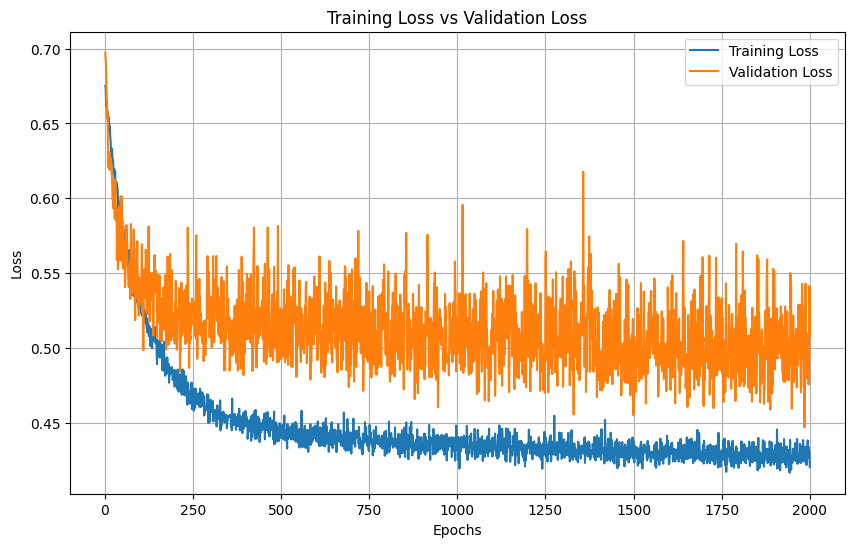

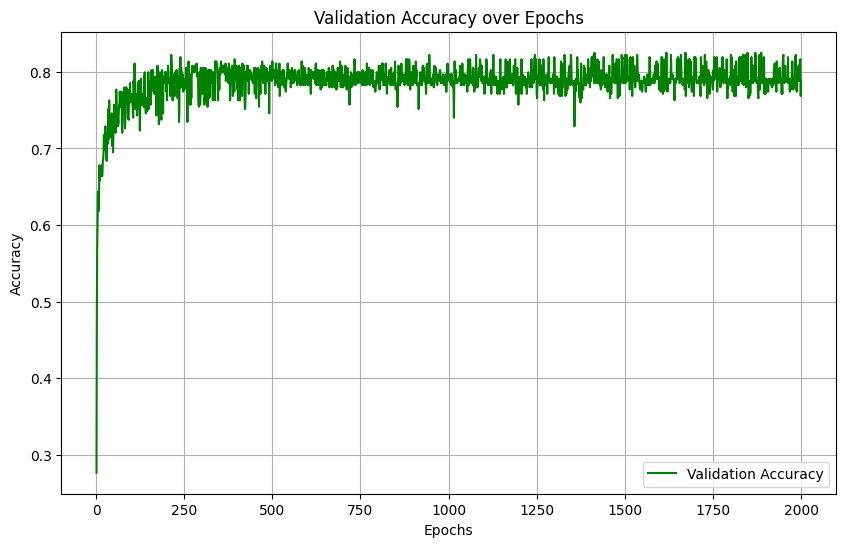

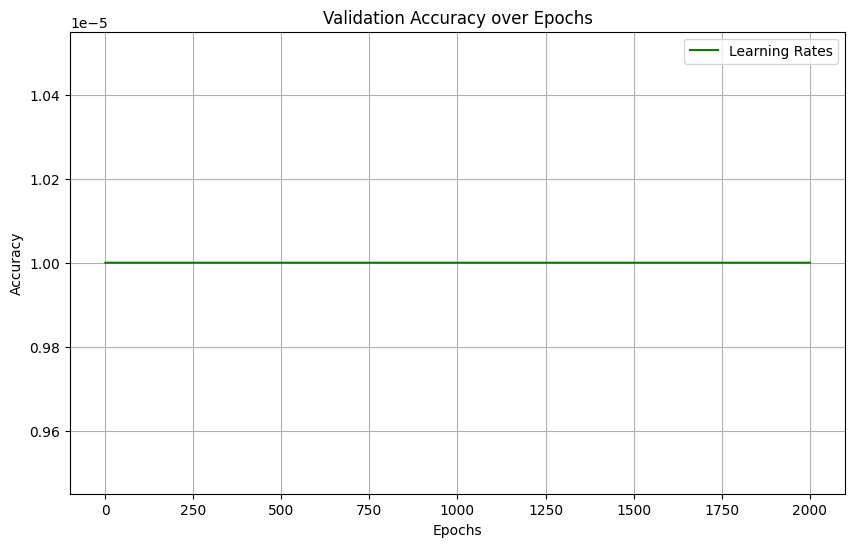

Model for bin 1 saved to GATModels-5A_exp1_v3/Models/model_bin_1.pth
Attention weights for bin 1 saved to GATModels-5A_exp1_v3/Weights/attn_bin_1.pt
Training on bin 2/50
Bin 2, Epoch 1/2000, Train Loss: 0.7709, Validation Loss: 0.7127,  ValAccuracy: 0.2175, LR: 0.000010
Bin 2, Epoch 101/2000, Train Loss: 0.5520, Validation Loss: 0.5678,  ValAccuracy: 0.7599, LR: 0.000010
Bin 2, Epoch 201/2000, Train Loss: 0.5036, Validation Loss: 0.5342,  ValAccuracy: 0.7740, LR: 0.000010
Bin 2, Epoch 301/2000, Train Loss: 0.4850, Validation Loss: 0.4990,  ValAccuracy: 0.8164, LR: 0.000010
Bin 2, Epoch 401/2000, Train Loss: 0.4796, Validation Loss: 0.5337,  ValAccuracy: 0.7571, LR: 0.000010
Bin 2, Epoch 501/2000, Train Loss: 0.4588, Validation Loss: 0.4602,  ValAccuracy: 0.8305, LR: 0.000010
Bin 2, Epoch 601/2000, Train Loss: 0.4603, Validation Loss: 0.4853,  ValAccuracy: 0.7797, LR: 0.000010
Bin 2, Epoch 701/2000, Train Loss: 0.4579, Validation Loss: 0.4879,  ValAccuracy: 0.7797, LR: 0.000010
Bin 2, E

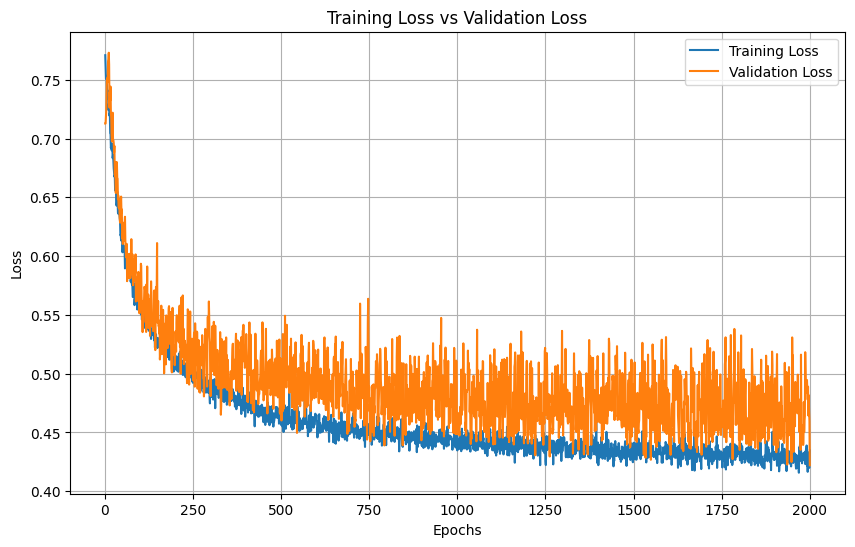

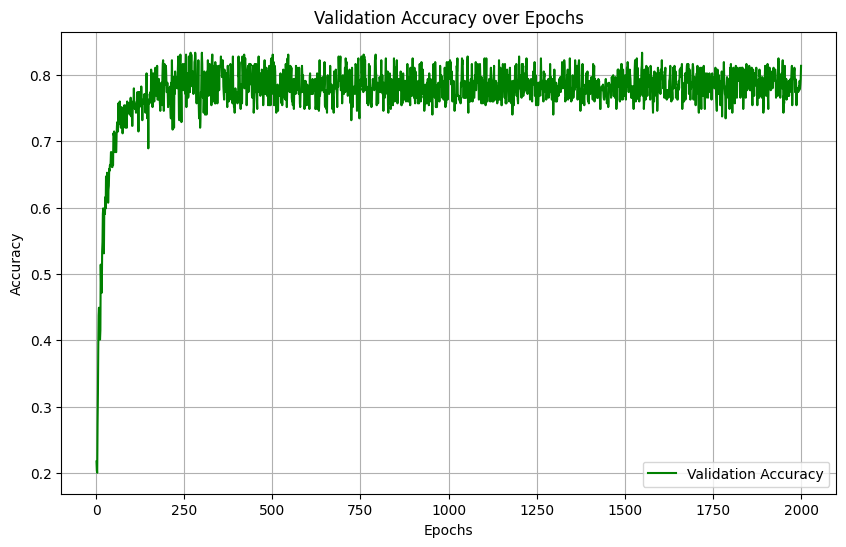

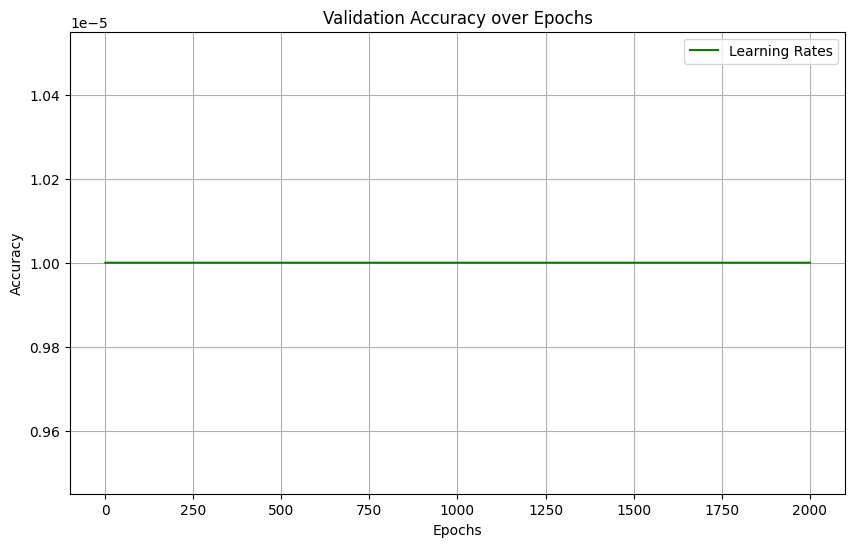

Model for bin 2 saved to GATModels-5A_exp1_v3/Models/model_bin_2.pth
Attention weights for bin 2 saved to GATModels-5A_exp1_v3/Weights/attn_bin_2.pt
Training on bin 3/50
Bin 3, Epoch 1/2000, Train Loss: 0.6576, Validation Loss: 0.7142,  ValAccuracy: 0.2203, LR: 0.000010
Bin 3, Epoch 101/2000, Train Loss: 0.5547, Validation Loss: 0.5303,  ValAccuracy: 0.7712, LR: 0.000010
Bin 3, Epoch 201/2000, Train Loss: 0.5182, Validation Loss: 0.5060,  ValAccuracy: 0.7938, LR: 0.000010
Bin 3, Epoch 301/2000, Train Loss: 0.4953, Validation Loss: 0.4931,  ValAccuracy: 0.7881, LR: 0.000010
Bin 3, Epoch 401/2000, Train Loss: 0.4782, Validation Loss: 0.5334,  ValAccuracy: 0.7514, LR: 0.000010
Bin 3, Epoch 501/2000, Train Loss: 0.4719, Validation Loss: 0.4682,  ValAccuracy: 0.8079, LR: 0.000010
Bin 3, Epoch 601/2000, Train Loss: 0.4617, Validation Loss: 0.4808,  ValAccuracy: 0.7938, LR: 0.000010
Bin 3, Epoch 701/2000, Train Loss: 0.4667, Validation Loss: 0.5066,  ValAccuracy: 0.7768, LR: 0.000010
Bin 3, E

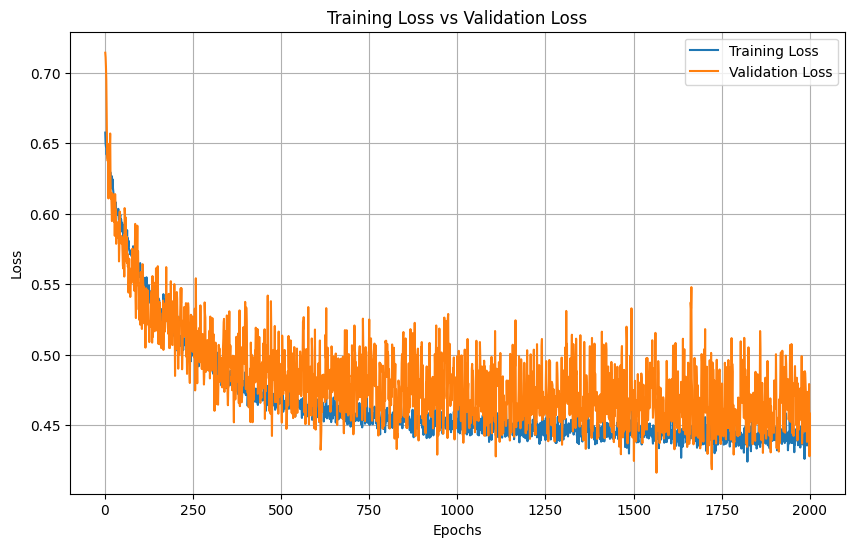

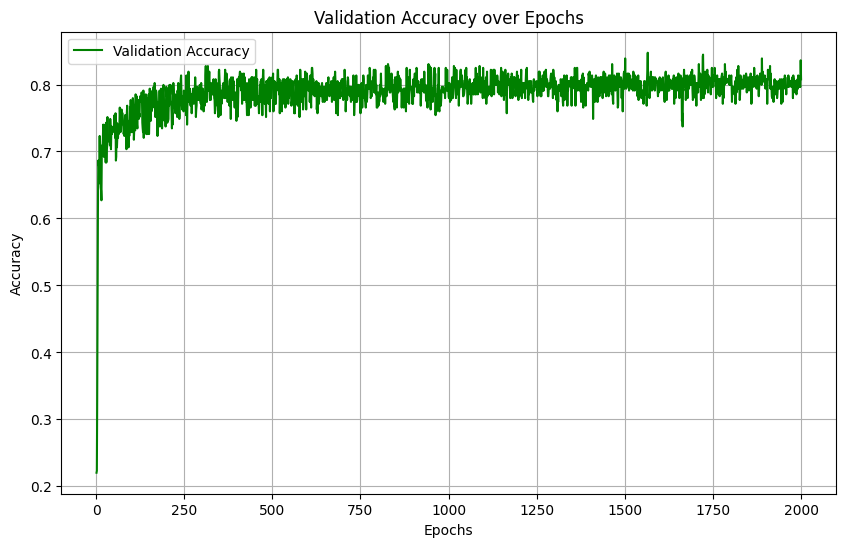

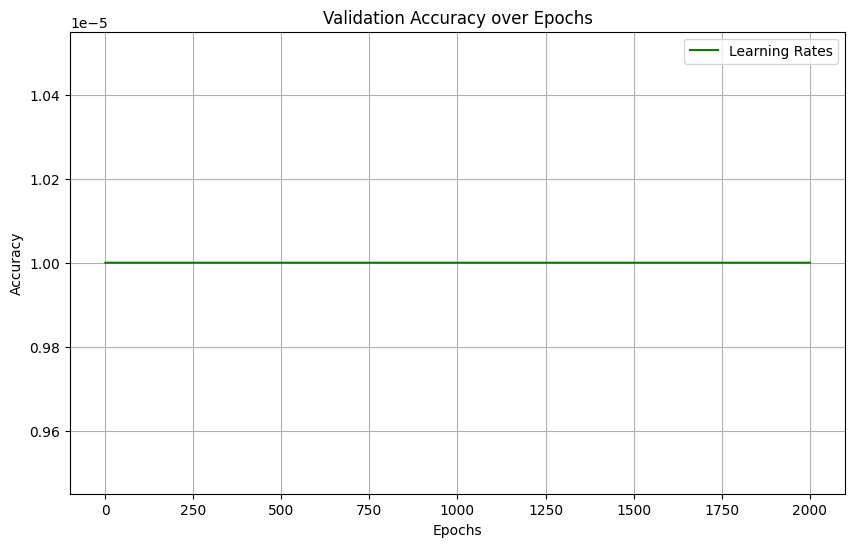

Model for bin 3 saved to GATModels-5A_exp1_v3/Models/model_bin_3.pth
Attention weights for bin 3 saved to GATModels-5A_exp1_v3/Weights/attn_bin_3.pt
Training on bin 4/50
Bin 4, Epoch 1/2000, Train Loss: 0.7375, Validation Loss: 0.6750,  ValAccuracy: 0.7768, LR: 0.000010
Bin 4, Epoch 101/2000, Train Loss: 0.5280, Validation Loss: 0.5442,  ValAccuracy: 0.7542, LR: 0.000010
Bin 4, Epoch 201/2000, Train Loss: 0.4959, Validation Loss: 0.5014,  ValAccuracy: 0.8023, LR: 0.000010
Bin 4, Epoch 301/2000, Train Loss: 0.4684, Validation Loss: 0.4883,  ValAccuracy: 0.8079, LR: 0.000010
Bin 4, Epoch 401/2000, Train Loss: 0.4511, Validation Loss: 0.4986,  ValAccuracy: 0.7881, LR: 0.000010
Bin 4, Epoch 501/2000, Train Loss: 0.4430, Validation Loss: 0.5014,  ValAccuracy: 0.7768, LR: 0.000010
Bin 4, Epoch 601/2000, Train Loss: 0.4285, Validation Loss: 0.4582,  ValAccuracy: 0.8277, LR: 0.000010
Bin 4, Epoch 701/2000, Train Loss: 0.4315, Validation Loss: 0.5085,  ValAccuracy: 0.7712, LR: 0.000010
Bin 4, E

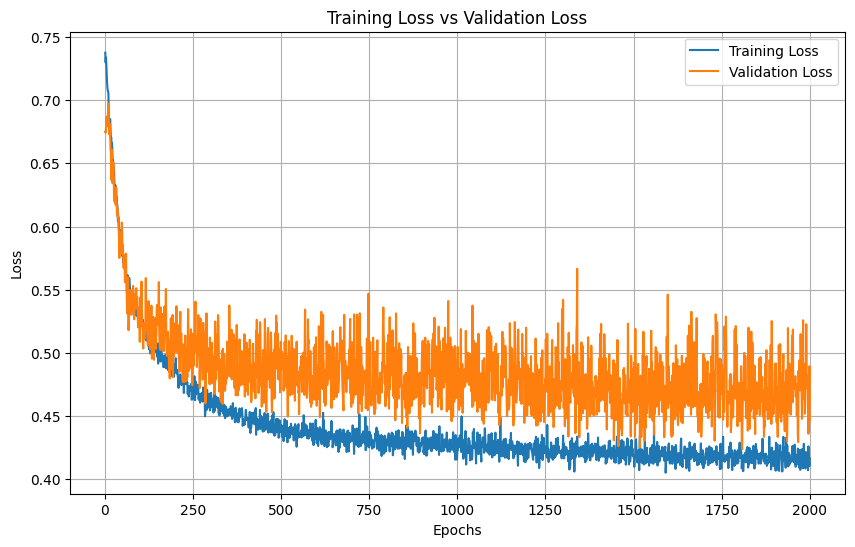

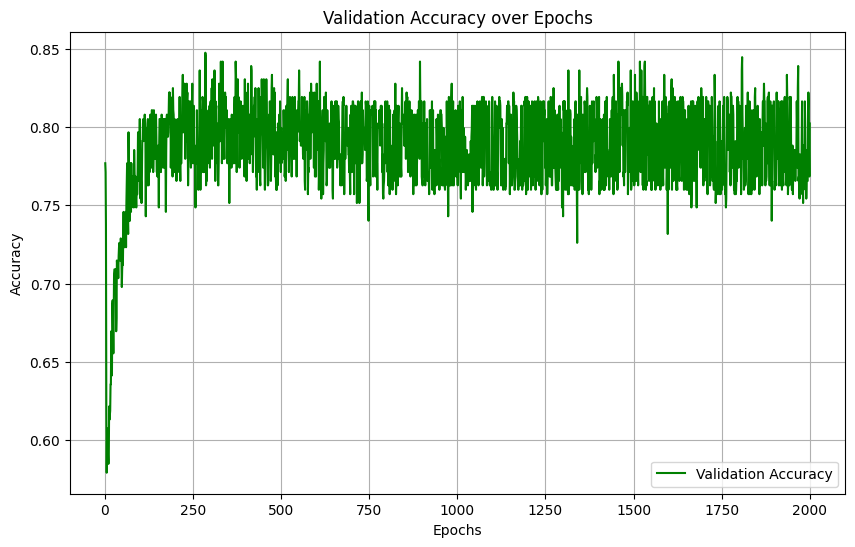

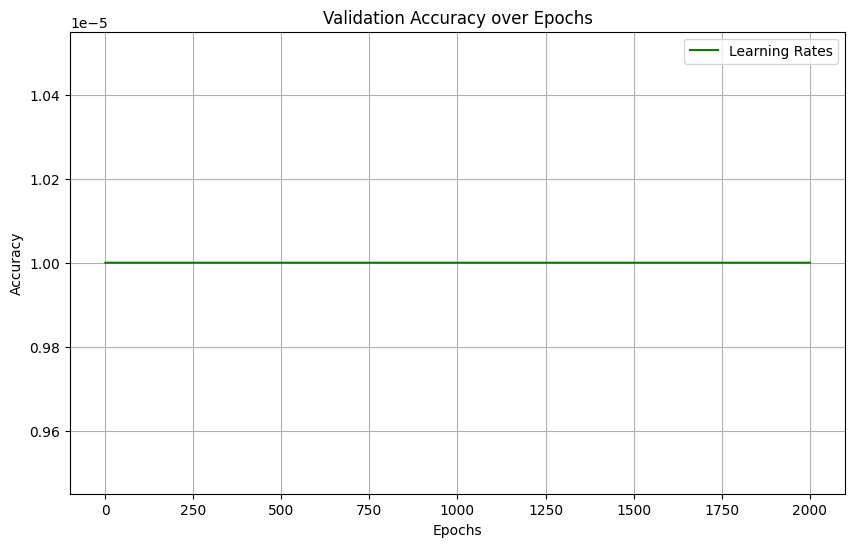

Model for bin 4 saved to GATModels-5A_exp1_v3/Models/model_bin_4.pth
Attention weights for bin 4 saved to GATModels-5A_exp1_v3/Weights/attn_bin_4.pt
Training on bin 5/50
Bin 5, Epoch 1/2000, Train Loss: 0.7487, Validation Loss: 0.7049,  ValAccuracy: 0.2119, LR: 0.000010
Bin 5, Epoch 101/2000, Train Loss: 0.5296, Validation Loss: 0.5104,  ValAccuracy: 0.7853, LR: 0.000010
Bin 5, Epoch 201/2000, Train Loss: 0.5019, Validation Loss: 0.5303,  ValAccuracy: 0.7571, LR: 0.000010
Bin 5, Epoch 301/2000, Train Loss: 0.4888, Validation Loss: 0.5035,  ValAccuracy: 0.7768, LR: 0.000010
Bin 5, Epoch 401/2000, Train Loss: 0.4833, Validation Loss: 0.5127,  ValAccuracy: 0.7712, LR: 0.000010
Bin 5, Epoch 501/2000, Train Loss: 0.4826, Validation Loss: 0.5187,  ValAccuracy: 0.7486, LR: 0.000010
Bin 5, Epoch 601/2000, Train Loss: 0.4591, Validation Loss: 0.5055,  ValAccuracy: 0.7768, LR: 0.000010
Bin 5, Epoch 701/2000, Train Loss: 0.4572, Validation Loss: 0.5260,  ValAccuracy: 0.7401, LR: 0.000010
Bin 5, E

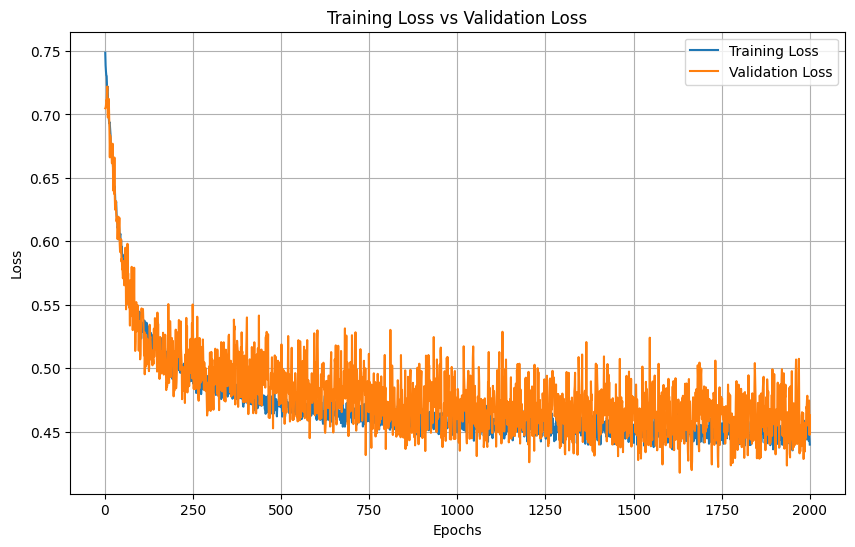

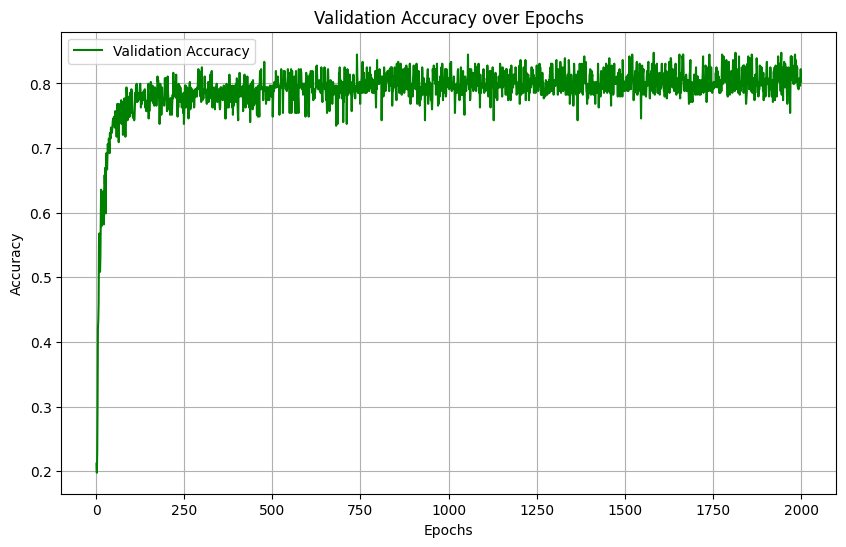

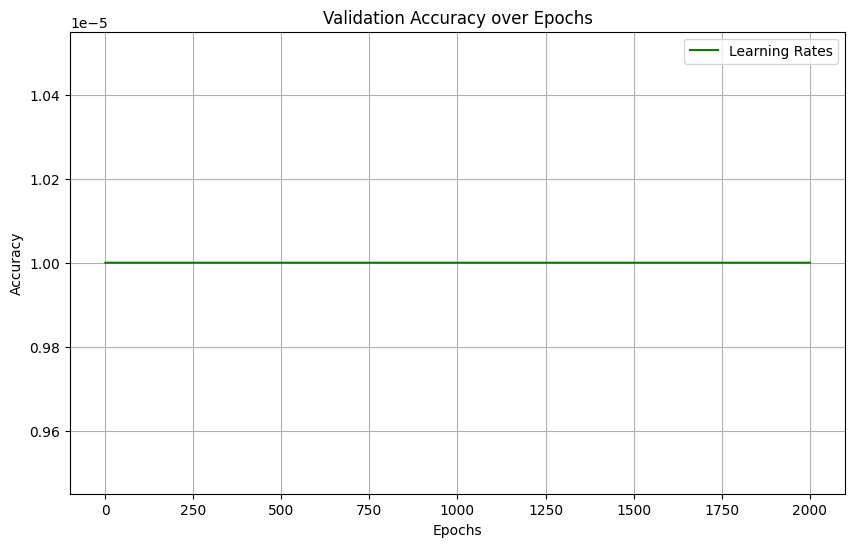

Model for bin 5 saved to GATModels-5A_exp1_v3/Models/model_bin_5.pth
Attention weights for bin 5 saved to GATModels-5A_exp1_v3/Weights/attn_bin_5.pt
Training on bin 6/50
Bin 6, Epoch 1/2000, Train Loss: 0.8049, Validation Loss: 0.7091,  ValAccuracy: 0.2175, LR: 0.000010
Bin 6, Epoch 101/2000, Train Loss: 0.5568, Validation Loss: 0.5548,  ValAccuracy: 0.7797, LR: 0.000010
Bin 6, Epoch 201/2000, Train Loss: 0.5014, Validation Loss: 0.5342,  ValAccuracy: 0.7797, LR: 0.000010
Bin 6, Epoch 301/2000, Train Loss: 0.4727, Validation Loss: 0.5517,  ValAccuracy: 0.7542, LR: 0.000010
Bin 6, Epoch 401/2000, Train Loss: 0.4602, Validation Loss: 0.5586,  ValAccuracy: 0.7458, LR: 0.000010
Bin 6, Epoch 501/2000, Train Loss: 0.4535, Validation Loss: 0.5334,  ValAccuracy: 0.7740, LR: 0.000010
Bin 6, Epoch 601/2000, Train Loss: 0.4490, Validation Loss: 0.5388,  ValAccuracy: 0.7740, LR: 0.000010
Bin 6, Epoch 701/2000, Train Loss: 0.4344, Validation Loss: 0.5234,  ValAccuracy: 0.7797, LR: 0.000010
Bin 6, E

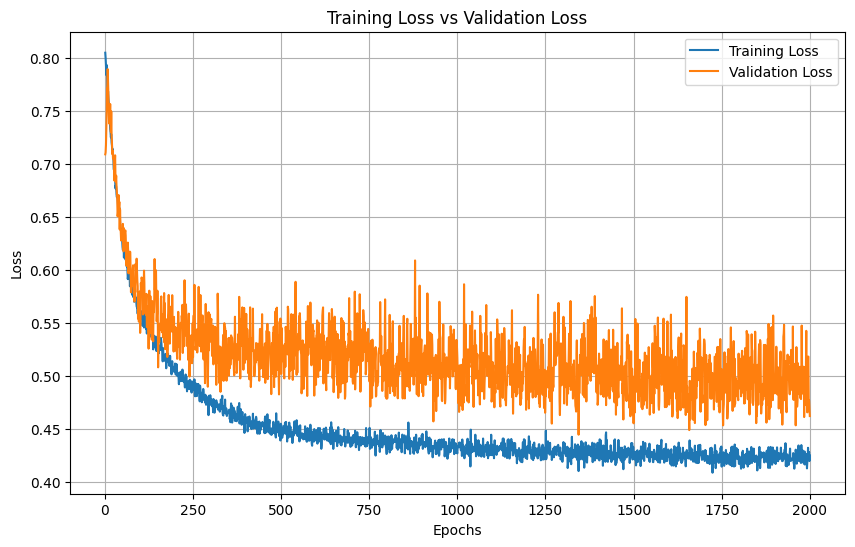

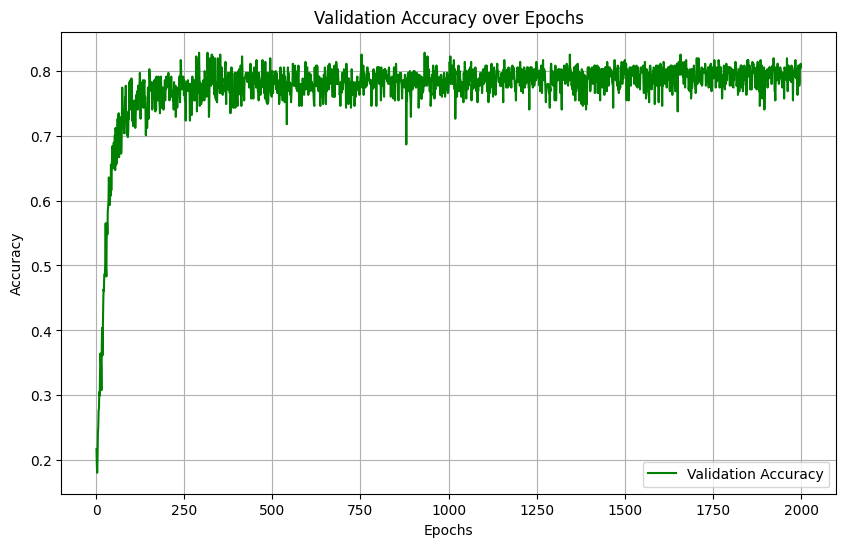

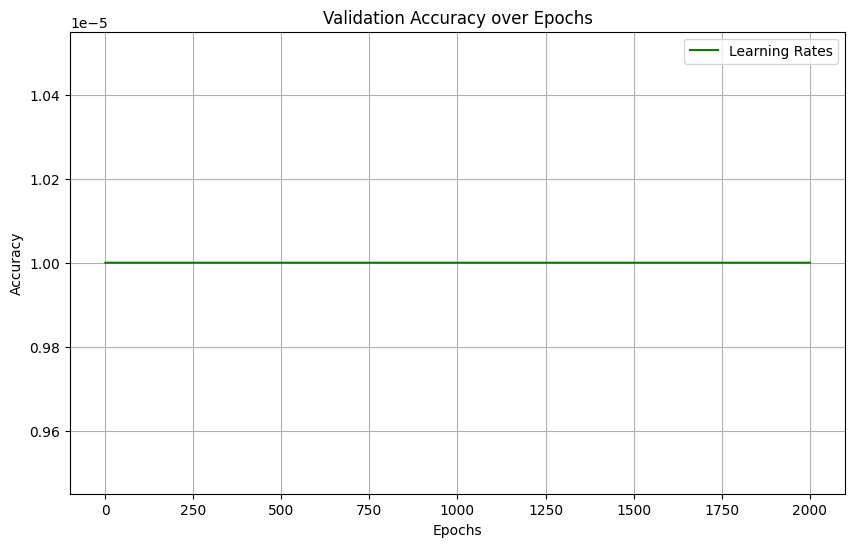

Model for bin 6 saved to GATModels-5A_exp1_v3/Models/model_bin_6.pth
Attention weights for bin 6 saved to GATModels-5A_exp1_v3/Weights/attn_bin_6.pt
Training on bin 7/50
Bin 7, Epoch 1/2000, Train Loss: 0.6623, Validation Loss: 0.7069,  ValAccuracy: 0.2203, LR: 0.000010
Bin 7, Epoch 101/2000, Train Loss: 0.5096, Validation Loss: 0.5267,  ValAccuracy: 0.7599, LR: 0.000010
Bin 7, Epoch 201/2000, Train Loss: 0.4823, Validation Loss: 0.4923,  ValAccuracy: 0.7825, LR: 0.000010
Bin 7, Epoch 301/2000, Train Loss: 0.4751, Validation Loss: 0.5206,  ValAccuracy: 0.7514, LR: 0.000010
Bin 7, Epoch 401/2000, Train Loss: 0.4635, Validation Loss: 0.4911,  ValAccuracy: 0.7825, LR: 0.000010
Bin 7, Epoch 501/2000, Train Loss: 0.4614, Validation Loss: 0.4646,  ValAccuracy: 0.8136, LR: 0.000010
Bin 7, Epoch 601/2000, Train Loss: 0.4430, Validation Loss: 0.4678,  ValAccuracy: 0.8051, LR: 0.000010
Bin 7, Epoch 701/2000, Train Loss: 0.4480, Validation Loss: 0.5007,  ValAccuracy: 0.7797, LR: 0.000010
Bin 7, E

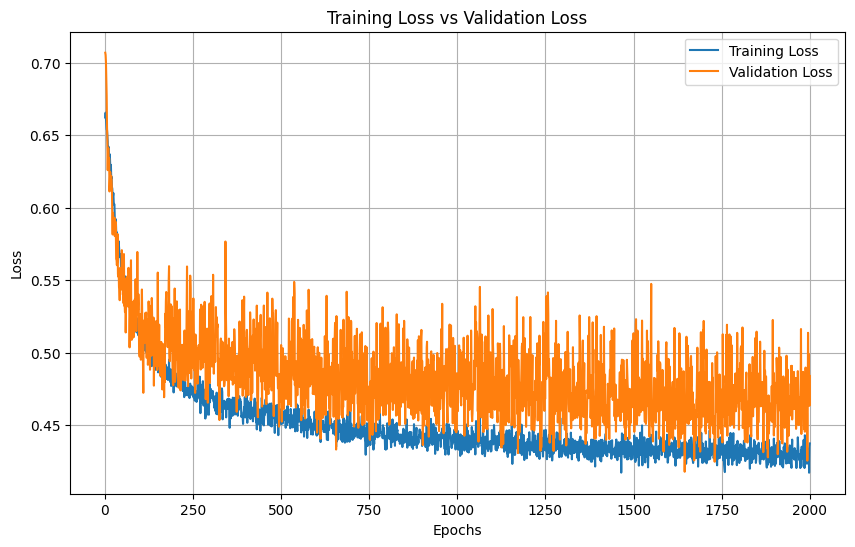

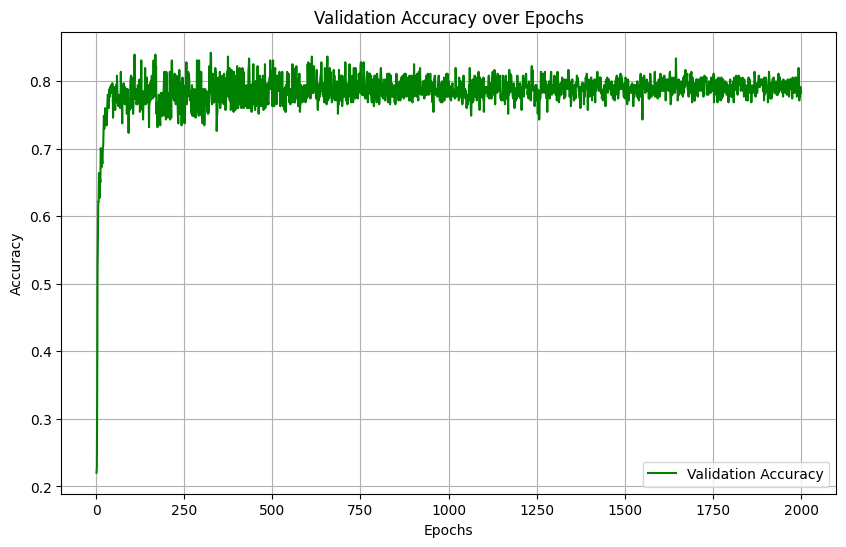

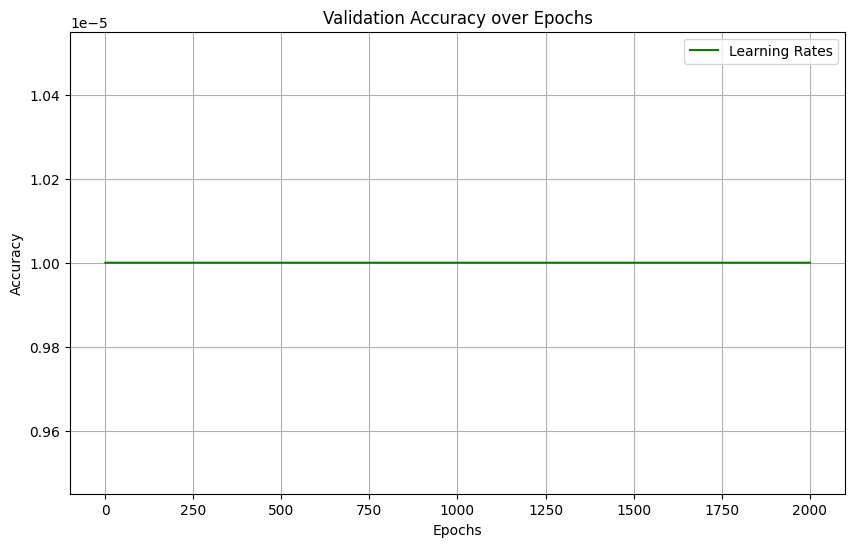

Model for bin 7 saved to GATModels-5A_exp1_v3/Models/model_bin_7.pth
Attention weights for bin 7 saved to GATModels-5A_exp1_v3/Weights/attn_bin_7.pt
Training on bin 8/50
Bin 8, Epoch 1/2000, Train Loss: 0.7592, Validation Loss: 0.7017,  ValAccuracy: 0.2175, LR: 0.000010
Bin 8, Epoch 101/2000, Train Loss: 0.5778, Validation Loss: 0.5318,  ValAccuracy: 0.7994, LR: 0.000010
Bin 8, Epoch 201/2000, Train Loss: 0.5301, Validation Loss: 0.5362,  ValAccuracy: 0.7740, LR: 0.000010
Bin 8, Epoch 301/2000, Train Loss: 0.4999, Validation Loss: 0.4969,  ValAccuracy: 0.8192, LR: 0.000010
Bin 8, Epoch 401/2000, Train Loss: 0.4822, Validation Loss: 0.5090,  ValAccuracy: 0.7797, LR: 0.000010
Bin 8, Epoch 501/2000, Train Loss: 0.4794, Validation Loss: 0.4907,  ValAccuracy: 0.7853, LR: 0.000010
Bin 8, Epoch 601/2000, Train Loss: 0.4799, Validation Loss: 0.4948,  ValAccuracy: 0.7655, LR: 0.000010
Bin 8, Epoch 701/2000, Train Loss: 0.4787, Validation Loss: 0.4621,  ValAccuracy: 0.8023, LR: 0.000010
Bin 8, E

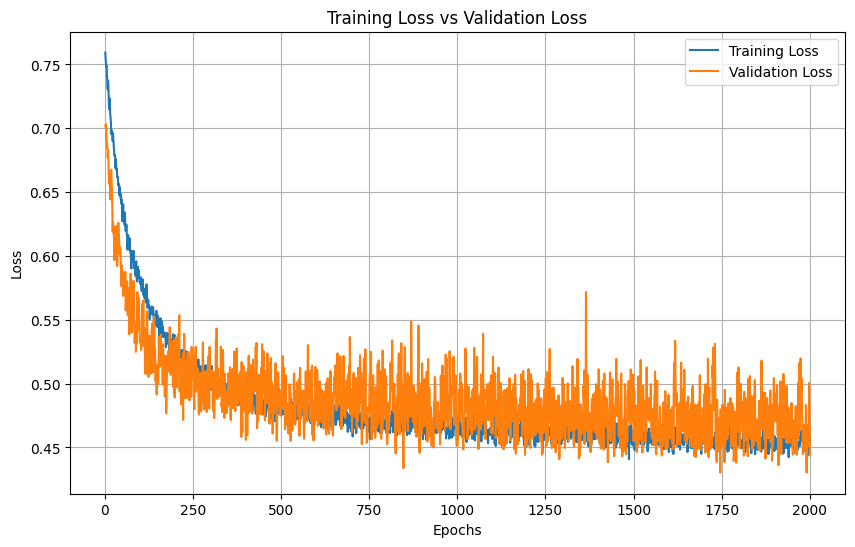

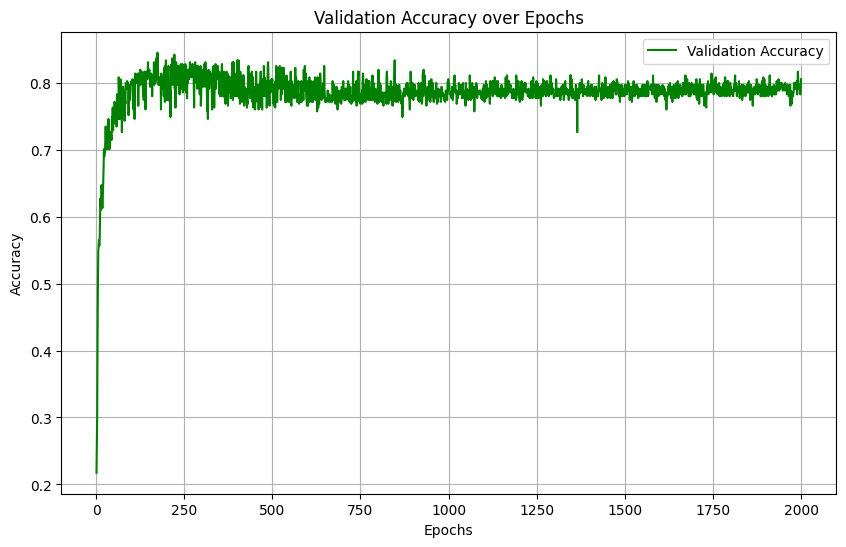

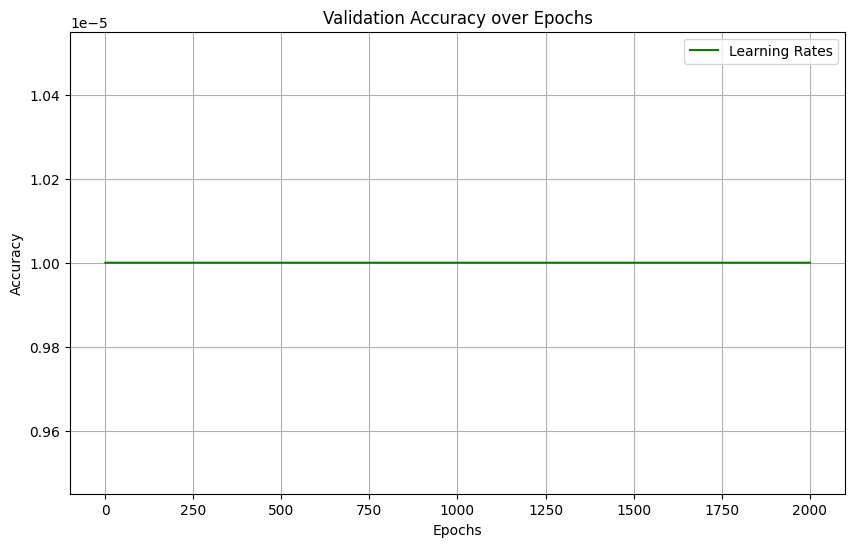

Model for bin 8 saved to GATModels-5A_exp1_v3/Models/model_bin_8.pth
Attention weights for bin 8 saved to GATModels-5A_exp1_v3/Weights/attn_bin_8.pt
Training on bin 9/50
Bin 9, Epoch 1/2000, Train Loss: 0.7151, Validation Loss: 0.6865,  ValAccuracy: 0.7966, LR: 0.000010
Bin 9, Epoch 101/2000, Train Loss: 0.5402, Validation Loss: 0.5466,  ValAccuracy: 0.7542, LR: 0.000010
Bin 9, Epoch 201/2000, Train Loss: 0.4964, Validation Loss: 0.4915,  ValAccuracy: 0.8107, LR: 0.000010
Bin 9, Epoch 301/2000, Train Loss: 0.4779, Validation Loss: 0.4690,  ValAccuracy: 0.8305, LR: 0.000010
Bin 9, Epoch 401/2000, Train Loss: 0.4694, Validation Loss: 0.4897,  ValAccuracy: 0.7910, LR: 0.000010
Bin 9, Epoch 501/2000, Train Loss: 0.4647, Validation Loss: 0.4918,  ValAccuracy: 0.7825, LR: 0.000010
Bin 9, Epoch 601/2000, Train Loss: 0.4672, Validation Loss: 0.4499,  ValAccuracy: 0.8192, LR: 0.000010
Bin 9, Epoch 701/2000, Train Loss: 0.4621, Validation Loss: 0.4970,  ValAccuracy: 0.7712, LR: 0.000010
Bin 9, E

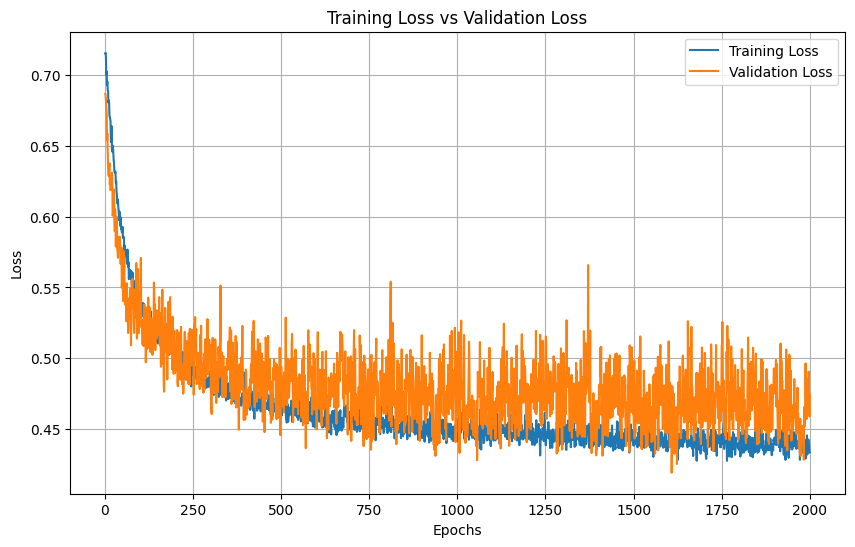

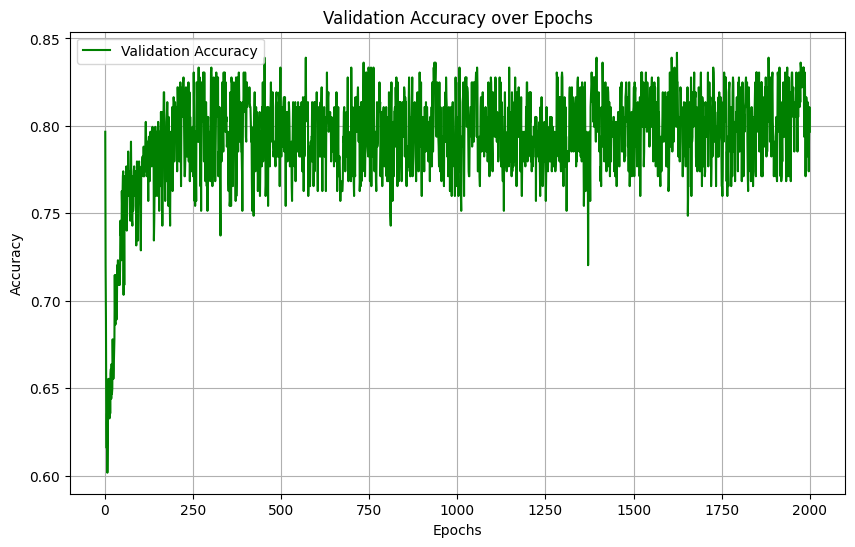

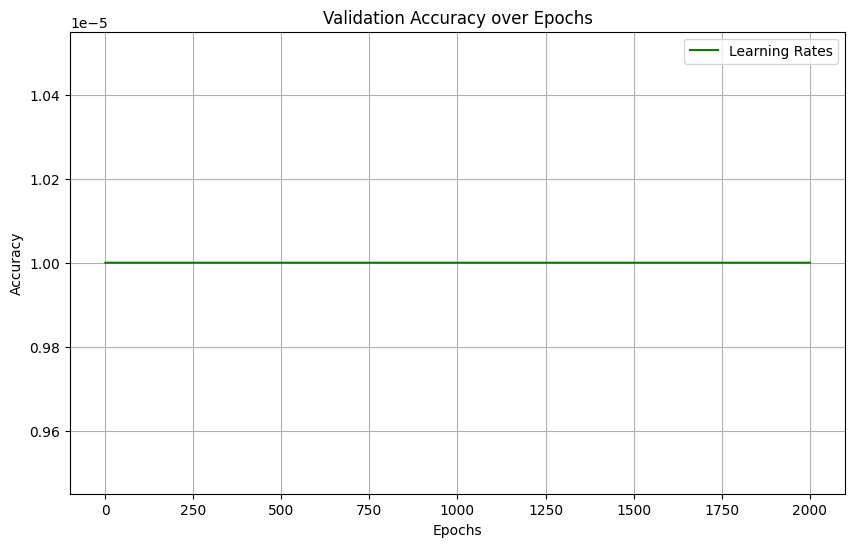

Model for bin 9 saved to GATModels-5A_exp1_v3/Models/model_bin_9.pth
Attention weights for bin 9 saved to GATModels-5A_exp1_v3/Weights/attn_bin_9.pt
Training on bin 10/50
Bin 10, Epoch 1/2000, Train Loss: 0.6855, Validation Loss: 0.6860,  ValAccuracy: 0.7938, LR: 0.000010
Bin 10, Epoch 101/2000, Train Loss: 0.5473, Validation Loss: 0.5242,  ValAccuracy: 0.7994, LR: 0.000010
Bin 10, Epoch 201/2000, Train Loss: 0.5177, Validation Loss: 0.5183,  ValAccuracy: 0.7825, LR: 0.000010
Bin 10, Epoch 301/2000, Train Loss: 0.4929, Validation Loss: 0.5012,  ValAccuracy: 0.7938, LR: 0.000010


KeyboardInterrupt: 

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define paths for saving models
save_dir = "GATModels-5A_exp1_v3"
os.makedirs(f"{save_dir}/Models", exist_ok=True)
os.makedirs(f"{save_dir}/Weights", exist_ok=True)

epochs = 2000
batch_size = 64

val_loader = DataLoader(validation_graphs, batch_size=batch_size, shuffle=False)

for i, bin in enumerate(bins[0:50], start=0):
    model = GAT(in_channels=37, out_channels=128).to(device)
    criterion = nn.BCEWithLogitsLoss()  
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

    train_loader = DataLoader(bin, batch_size=batch_size, shuffle=True)    

    print(f"Training on bin {i+1}/{len(bins)}")

    train_losses = []
    learning_rates = []
    validation_losses = []
    validation_accuracies = []

    for epoch in range(epochs):
        epoch_loss, accuracy = train_model(model, train_loader, criterion, optimizer, device)
        validation_loss, validation_accuracy, attention_data = validate_model(model, val_loader, criterion, device)
        #scheduler.step()
        
        current_lr = optimizer.param_groups[0]['lr'] 
        train_losses.append(epoch_loss)
        learning_rates.append(current_lr)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)   
        if epoch % 100 == 0:
            print(
                f"Bin {i+1}, Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {epoch_loss:.4f}, Validation Loss: {validation_loss:.4f},  "
                f"ValAccuracy: {validation_accuracy:.4f}, "
                f"LR: {current_lr:.6f}"
            )
                
    plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates)

    #Save the trained model
    model_path = os.path.join(save_dir, f"Models/model_bin_{i+1}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for bin {i+1} saved to {model_path}")

    # Save attention weights
    attn_path = os.path.join(save_dir, f"Weights/attn_bin_{i+1}.pt")
    torch.save(attention_data, attn_path)
    print(f"Attention weights for bin {i+1} saved to {attn_path}")
